sbatch SpikeCounter/cluster/run_array_autosegmentation.sh /n/holyscratch01/cohen_lab/bjia/20220120_cavMO_widefield_bifurcation/analysis/experiment_data.csv /n/holyscratch01/cohen_lab/bjia/20220120_cavMO_widefield_bifurcation/corrected 0 0 1 2 201 0.01 0.5 0.5 0.15 2.5

In [36]:
import sys
from pathlib import Path
import os
import warnings
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)
from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize

In [12]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from datetime import datetime
import scipy.signal as signal
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.optimize as optimize
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import os
from scipy.io import savemat
from skimage import transform, measure
import skimage.io as skio
import importlib
import colorcet as cc
plt.style.use("../bio_pubs_presentation.mplstyle")

In [3]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220120_cavMO_widefield_bifurcation/corrected"

In [37]:
expt_dir_name = "20220120_cavMO_widefield_bifurcation"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_dir_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure4/", expt_dir_name)
os.makedirs(output_datadir, exist_ok=True)
subfolder = "corrected"

In [4]:
fs=10.2
start_hpf = 19
expt_info = utils.process_experiment_metadata(pd.read_csv(os.path.join(rootdir,"analysis/experiment_data.csv")))
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

### Load segmented traces

In [5]:
dobj = traces.TimelapseArrayExperiment(os.path.join(rootdir, "analysis"),start_hpf, fs)

In [17]:
roi_map = skio.imread(os.path.join(rootdir,"analysis/segmentation_video.tif")).max(axis=0)
manual_masks = skio.imread(os.path.join(rootdir, "../manual_ROIs.tif"))
manual_masks[manual_masks > 0] +=3
roi_map += manual_masks

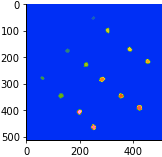

In [18]:
plt.imshow(roi_map)

In [78]:
def custom_lp_filter(raw, norm_thresh=0.8):
    sos = signal.butter(5, norm_thresh,output="sos")
    intensity = signal.sosfiltfilt(sos, raw)
#     mean_freq = 2.0
#     b, a = signal.butter(5, [mean_freq-0.2, mean_freq+0.2], btype="bandstop", fs=10.2)
#     intensity = signal.filtfilt(b, a, intensity)
    return intensity

In [6]:
usable_indices = np.arange(1, expt_info.shape[0])

In [7]:
dobj.load_traces(timepoints=usable_indices, per_trace_start=0, corr_photobleach=False, filter_function=lambda x: x)

In [34]:
dobj.analyze_peaks(threshold=0.015, prominence="snr", auto_prom_scale=5, \
                   wlen=30, min_width=2, max_width=30, baseline_duration=3000, baseline_start=1000,\
                  excl=1000)

In [81]:
dobj.analyze_peaks(threshold="auto", prominence="snr", auto_prom_scale=6, auto_thresh_scale=0.4, \
                   wlen=20, min_width=2, max_width=30, baseline_duration=3000, baseline_start=15000,\
                  excl=1000)

0.0019806443147652375
0.011883865888591425 0.010245572901667652
0.0017156853958054353
0.010294112374832612 0.009506347608970359
0.0015771668038622496
0.009463000823173497 0.010058868795922788
0.0016420812233703863
0.009852487340222317 0.001981537495624846
0.0011441710795142173
0.006865026477085303 0.0017075520263887909
0.0013684853905262496
0.008210912343157498 0.001864747293179378
0.0014767138499918871
0.008860283099951323 0.002449114086658613
0.0013211557541232943
0.007926934524739766 0.0021632053519694493
0.0012336452959050477
0.007401871775430286 0.0018125841731804811
0.001327865551166218
0.007967193306997309 0.0018280344803472222
0.001179019251890868
0.007074115511345208 0.0018411933409889477
0.0017529820367159323
0.010517892220295593 0.0022705349498363114


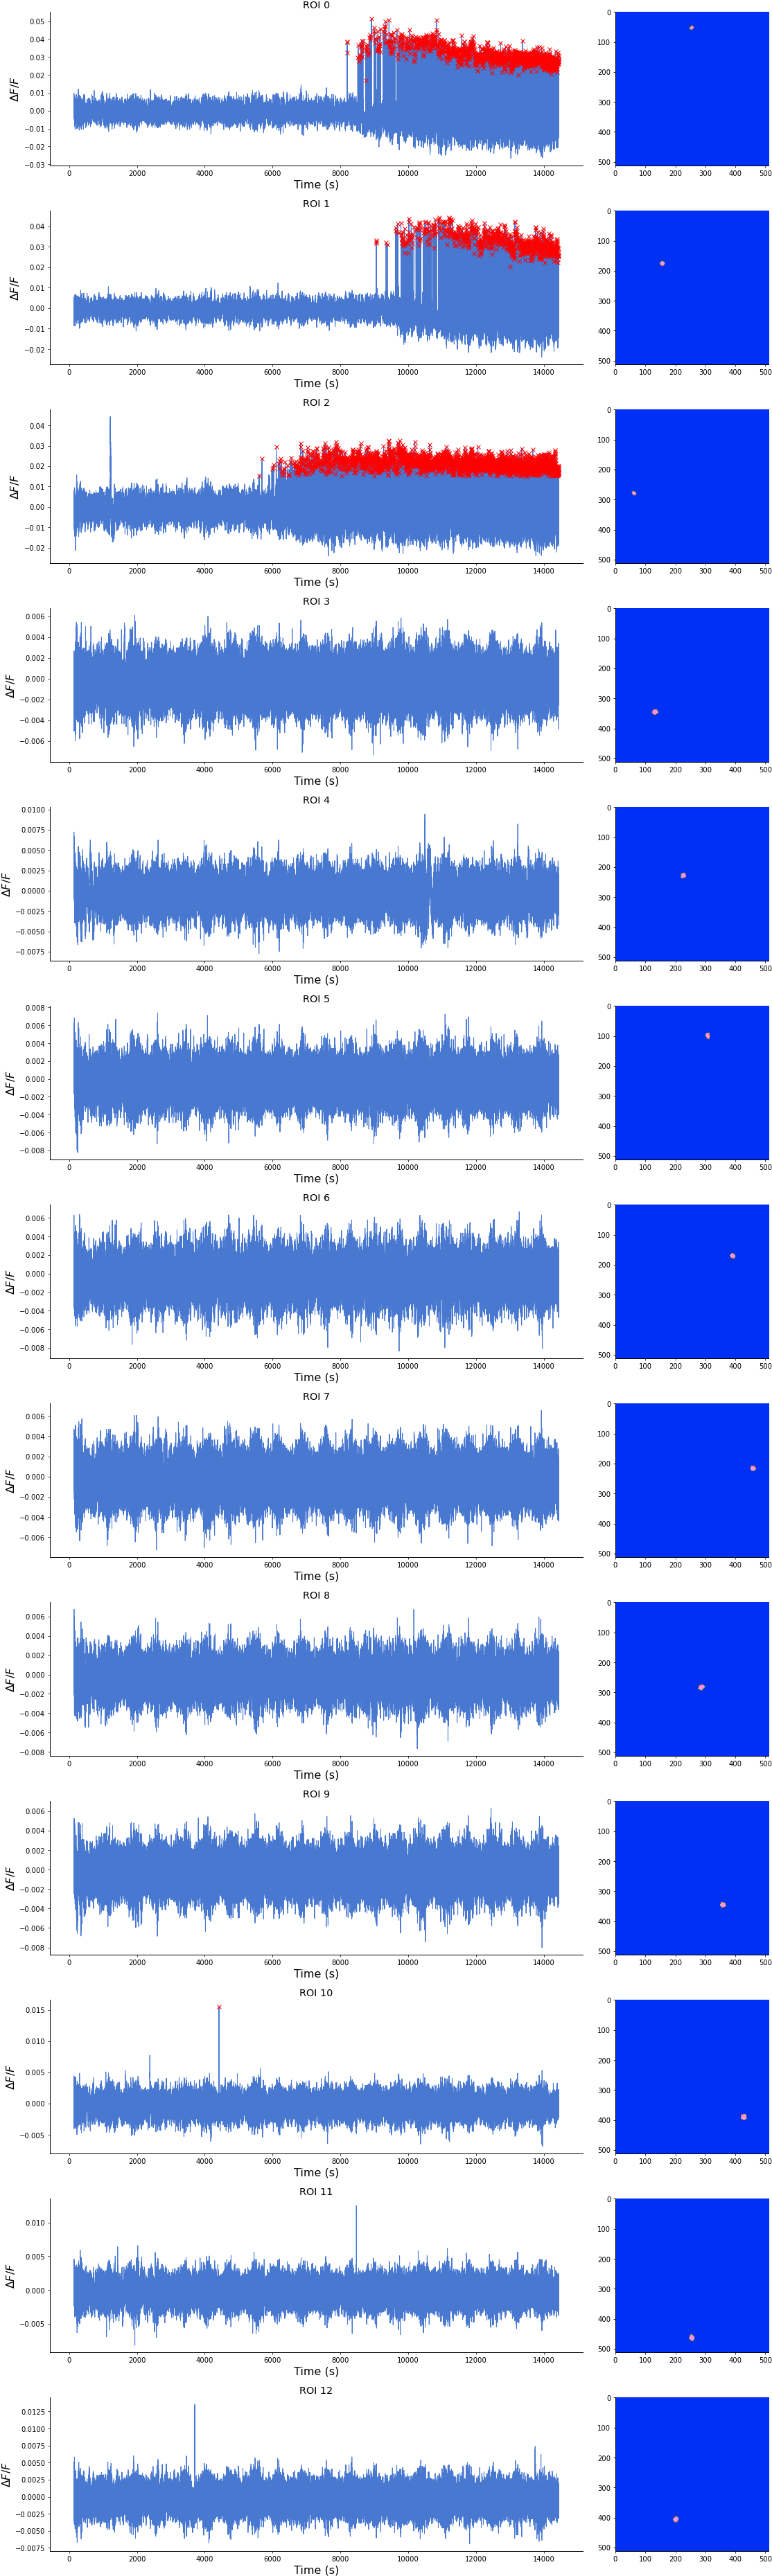

In [35]:
plt.close("all")
fig1, axes = dobj.plot_spikes_with_mask(roi_map)
plt.savefig(os.path.join(rootdir, "analysis", "spikeplots.svg"))

TypeError: object of type 'numpy.float64' has no len()

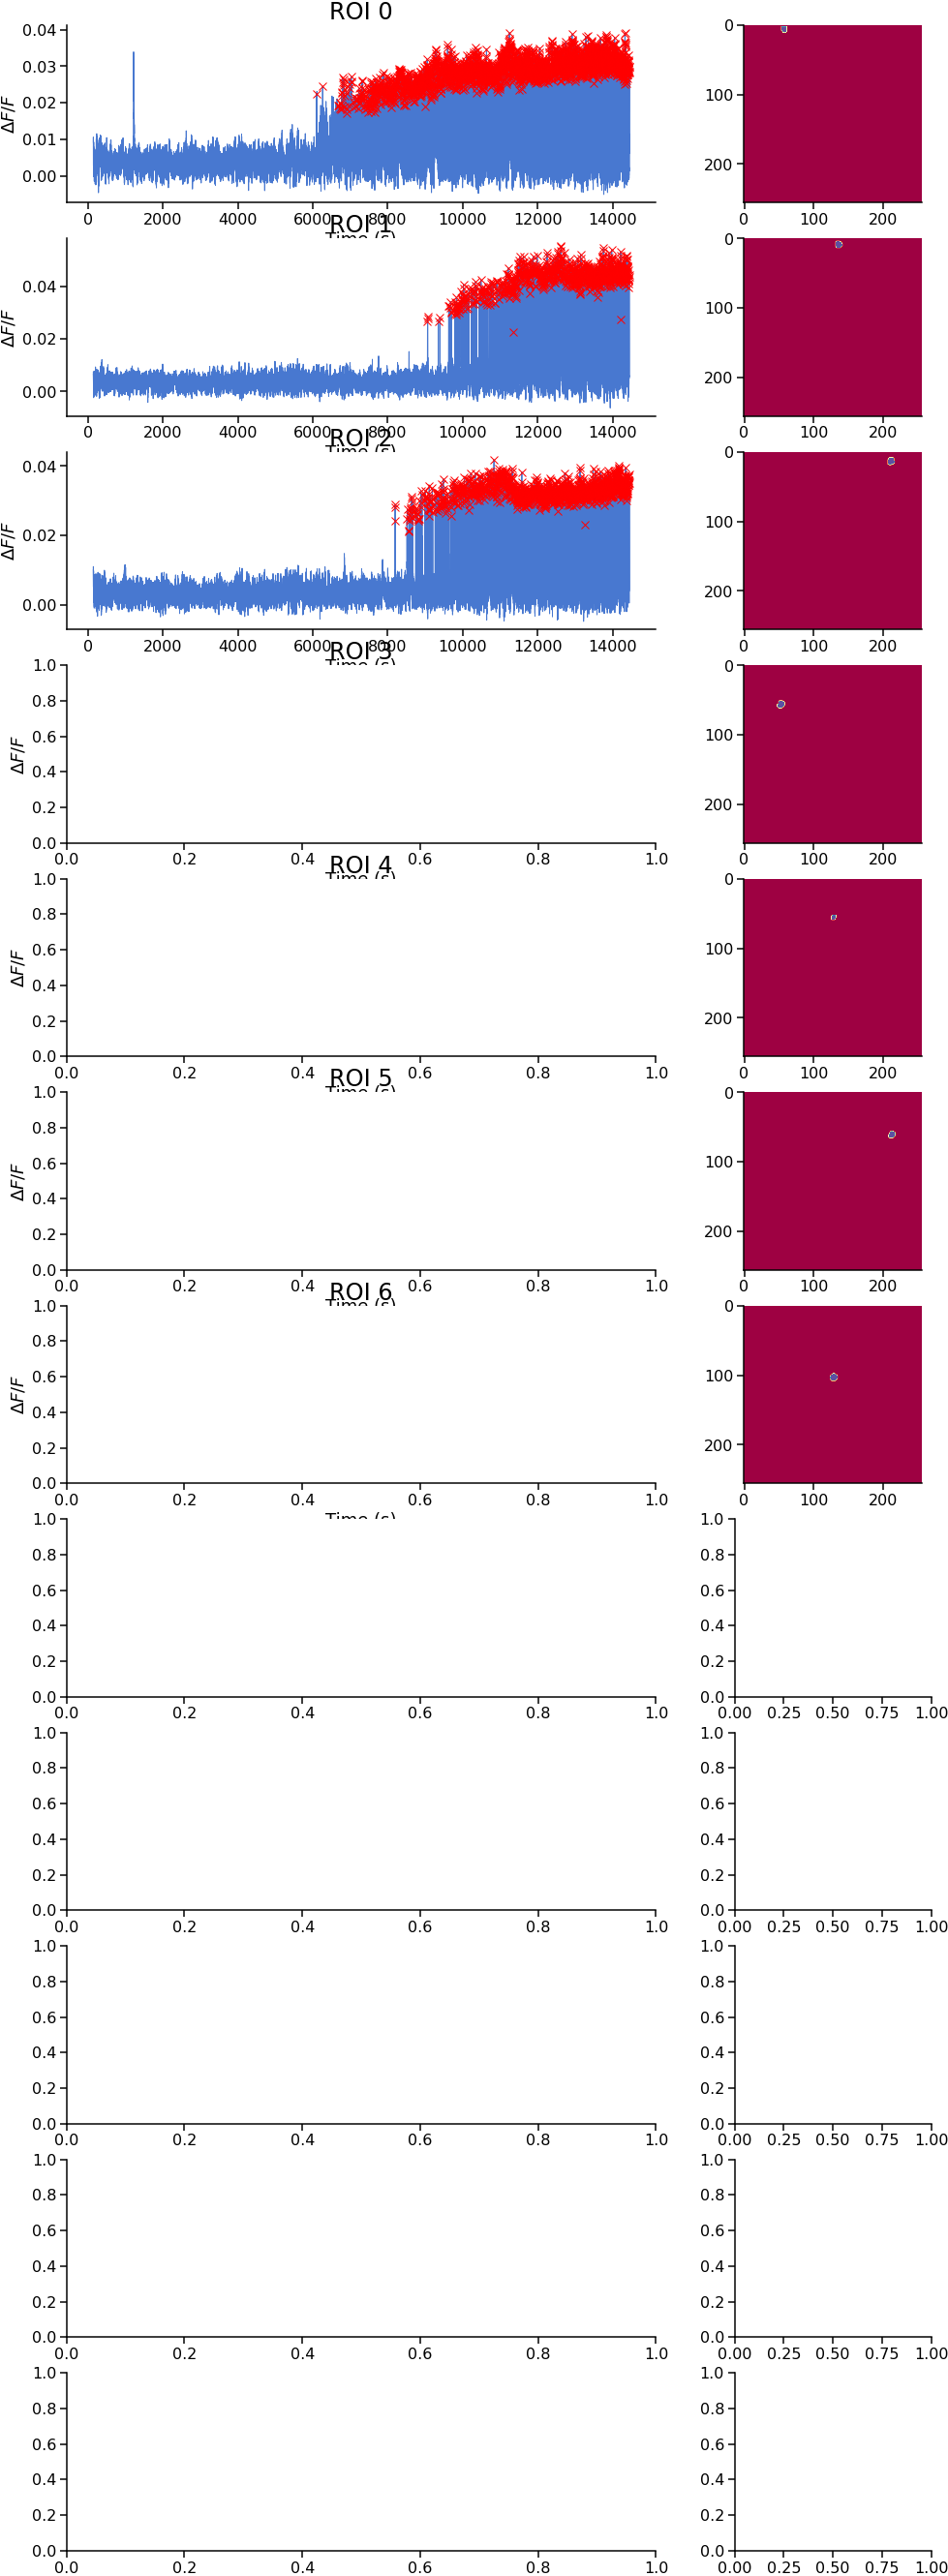

In [39]:
plt.close("all")
fig1, axes = dobj.plot_spikes_with_mask(roi_map)
plt.savefig(os.path.join(rootdir, "analysis", "spikeplots.svg"))

## Align embryos according to time of first spike

First try criterion based on interspike intervals

In [38]:
rois = dobj.peaks_data.index.unique()[:17]
offset_times = []
isi_threshold = 120
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
#     print(roi_data["isi"].to_numpy() < isi_threshold)
    try:
        isi = roi_data["isi"].to_numpy()
        offset_idx = np.argwhere((isi< isi_threshold)&(np.roll(isi, 1) < isi_threshold)).ravel()[0]
        offset_times.append(roi_data["t"].iloc[offset_idx])
    except 

AttributeError: 'numpy.float64' object has no attribute 'to_numpy'

In [47]:
dobj.peaks_data.to_csv(output_datadir/"peaks_data.csv")

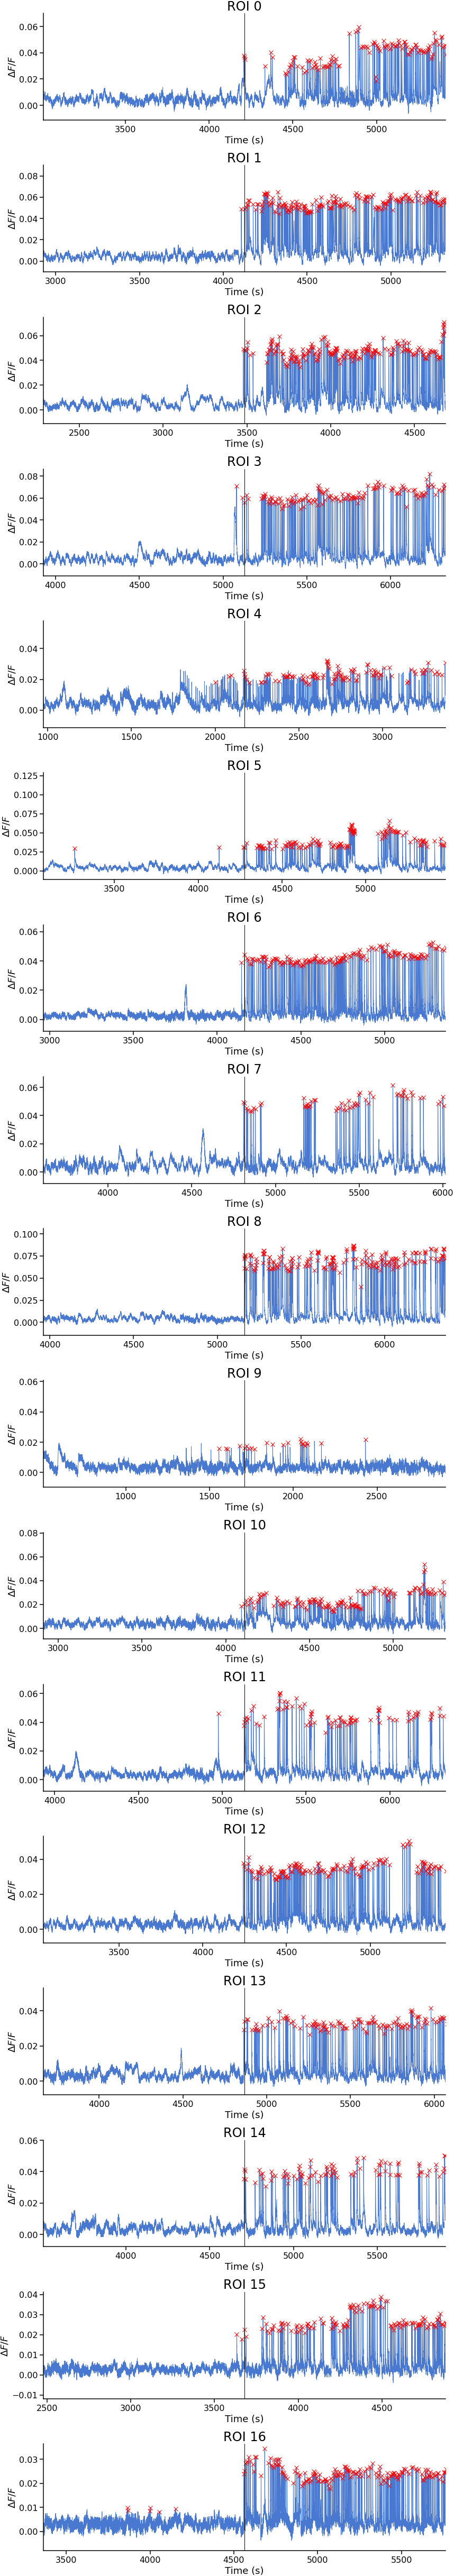

In [26]:
fig1, axes = dobj.plot_spikes(rois)
half_window = 1200
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((offset_times[idx]-half_window, offset_times[idx]+half_window))
    axes[idx].axvline(offset_times[idx], color="black")

### Check frequency change over developmental time for selected embryos

In [39]:
window_size=1800

In [42]:
droi, dsta, dststd = dobj.get_windowed_peak_stats(window_size, overlap=0.9, isi_stat_min_peaks=6)

In [44]:
lcs = np.zeros_like(rois)
lcs[3:] = 1

In [46]:
droi.index.unique()

Float64Index([0.0, 1.0, 2.0], dtype='float64', name='roi')

KeyError: 3

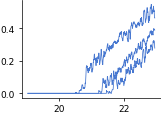

In [45]:
with plt.style.context("../bio_publications.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(2.5,1.8))
    for roi in rois:
        e_data = droi.loc[roi]
        ax1.plot(e_data["hpf"], e_data["mean_freq"], color="C%d" % lcs[int(roi)])
    ax1.set_xlabel("Developmental Time (hpf)")
    ax1.set_ylabel("Mean spike frequency (Hz)")
    handles, labels = plt.gca().get_legend_handles_labels()
    l1 = mlines.Line2D([0], [0], label='Control MO (n=3)', color='C0')
    l2 = mlines.Line2D([0], [0], label='cacna1c MO (n=9)', color='C1')
    handles.extend([l1,l2])
    ax1.legend(handles=handles, fontsize=7)

In [84]:
rois = droi.index.unique()

In [87]:
dobj.peaks_data.index.unique()

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64', name='roi')

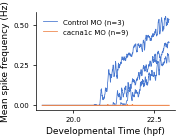

In [95]:
figdir = "/n/cohen_lab/Lab/Papers/First Heartbeat/Figures/v8"
with plt.style.context("../bio_publications.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(2.5,1.8))
    for roi in rois:
        e_data = droi.loc[roi]
        ax1.plot(e_data["hpf"], e_data["mean_freq"], color="C%d" % lcs[int(roi)])
    ax1.set_xlabel("Developmental Time (hpf)")
    ax1.set_ylabel("Mean spike frequency (Hz)")
    handles, labels = plt.gca().get_legend_handles_labels()
    l1 = mlines.Line2D([0], [0], label='Control MO (n=3)', color='C0')
    l2 = mlines.Line2D([0], [0], label='cacna1c MO (n=9)', color='C1')
    handles.extend([l1,l2])
    ax1.legend(handles=handles, fontsize=7)
    plt.savefig(os.path.join(figdir, "Figure3", "cavMO_widefield.svg"))